### **NLP using Tensorflow**

In [8]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)
import sys

sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow')
import important_functionalities as impf

In [2]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# shuffle training dataframe
train_df_shuffled=train_df.sample(frac=1,random_state=random_seed) # frac: percentage of  data to be shuffled
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [4]:
train_sentences,val_sentences,train_labels,val_labels=train_test_split(train_df_shuffled['text'].to_numpy(),train_df_shuffled['target'].to_numpy(),test_size=0.1,random_state=random_seed)

**19. Finding and Visualizing best-model's most wrong predictions**

In [13]:
import tensorflow_hub as hub
@kr.saving.register_keras_serializable(package="my_custom_package")
class UniversalEncodedLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)
        self.use_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
                                        input_shape = [],
                                        dtype=tf.string,
                                        trainable=False, # default=False,
                                        name='USE'
                                        )
    
    def call(self,inputs):
        return self.use_layer(inputs)

In [15]:
best_model= tf.keras.models.load_model('models/best_model.keras',custom_objects={"UniversalEncodedLayer":UniversalEncodedLayer})
best_model.compile(loss='binary_crossentropy',
                   metrics=['accuracy'],
                   optimizer=tf.keras.optimizers.Adam())
best_model.evaluate(val_sentences,val_labels)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7843 - loss: 0.4778


[0.4266805648803711, 0.8110235929489136]

In [16]:
# making predictions:
best_model_preds=best_model.predict(val_sentences)
thresh=0.5
best_model_preds_threshed=list(map(lambda x: 1 if x>thresh else 0,best_model_preds))

# calculating results:
best_model_results=impf.calculate_results(val_labels,best_model_preds_threshed)
best_model_results

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


{'accuracy': 81.10236220472441,
 'precision': 0.8113631917551808,
 'recall': 0.8110236220472441,
 'f1_score': 0.8102336058004984}

In [20]:
# create a Dataframe with validation sentences, validation labels and best performing model predictions + probs

val_df = pd.DataFrame({
    'text': val_sentences,
    'labels': val_labels,
    'pred': best_model_preds_threshed,
    'pred_probs':tf.squeeze(best_model_preds)
})

val_df.head()

,text,labels,pred,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0,0.171846
1,FedEx no longer to transport bioterror germs i...,0,1,0.818802
2,Gunmen kill four in El Salvador bus attack: Su...,1,1,0.990158
3,@camilacabello97 Internally and externally scr...,1,0,0.207547
4,Radiation emergency #preparedness starts with ...,1,1,0.758826


In [27]:
# find the wrong predictions and sort by prediction probs
most_wrong = val_df[val_df["labels"] != val_df['pred']].sort_values('pred_probs',ascending=False)
most_wrong[:10] # false positives

,text,labels,pred,pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1,0.935264
628,@noah_anyname That's where the concentration c...,0,1,0.920359
759,FedEx will no longer transport bioterror patho...,0,1,0.907498
49,@madonnamking RSPCA site multiple 7 story high...,0,1,0.882763
393,@SonofLiberty357 all illuminated by the bright...,0,1,0.857150
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1,0.856781
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1,0.842751
474,My phone looks like it was in a car ship airpl...,0,1,0.834963
251,@AshGhebranious civil rights continued in the ...,0,1,0.831767
381,Deaths 3 http://t.co/nApviyGKYK,0,1,0.831065


In [29]:
most_wrong[-10:] # false negatives

,text,labels,pred,pred_probs
221,going to redo my nails and watch behind the sc...,1,0,0.069941
681,'The way you move is like a full on rainstorm ...,1,0,0.063600
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0,0.063344
233,I get to smoke my shit in peace,1,0,0.058998
59,You can never escape me. Bullets don't harm me...,1,0,0.052501
408,@willienelson We need help! Horses will die!Pl...,1,0,0.049927
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0,0.046829
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0,0.046463
38,Why are you deluged with low self-image? Take ...,1,0,0.040831
23,Ron &amp; Fez - Dave's High School Crush https...,1,0,0.036164


In [30]:
# check the false positives (model predicted 1 when it should have been 0)
for row in most_wrong[:10].itertuples():
    _,text,label,pred,pred_prob = row
    print(f'Label: {label} Pred: {pred}, Prob: {pred_prob}')
    print(f'Text:\n{text}\n')
    print('----\n')

Label: 0 Pred: 1, Prob: 0.9352644681930542
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Label: 0 Pred: 1, Prob: 0.9203593730926514
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Label: 0 Pred: 1, Prob: 0.9074981808662415
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Label: 0 Pred: 1, Prob: 0.8827627897262573
Text:
@madonnamking RSPCA site multiple 7 story high rise buildings next to low density character residential in an area that floods

----

Label: 0 Pred: 1, Prob: 0.857150137424469
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Label: 0 Pred: 1, Prob: 0.8567811846733093
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Label: 0 Pred: 1, Prob: 0.842751204

In [31]:
# check the false negatives (model predicted 0 when it should have been 1)
for row in most_wrong[-10:].itertuples():
    _,text,label,pred,pred_prob = row
    print(f'Label: {label} Pred: {pred}, Prob: {pred_prob}')
    print(f'Text:\n{text}\n')
    print('----\n')

Label: 1 Pred: 0, Prob: 0.06994061172008514
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Label: 1 Pred: 0, Prob: 0.06360049545764923
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Label: 1 Pred: 0, Prob: 0.06334447860717773
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Label: 1 Pred: 0, Prob: 0.05899829417467117
Text:
I get to smoke my shit in peace

----

Label: 1 Pred: 0, Prob: 0.05250081419944763
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Label: 1 Pred: 0, Prob: 0.04992677643895149
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Label: 1 Pred: 0, Prob: 0.04682859778404236
Text:
@SoonerMagic_ I mean I'm a fan but

**20. Making predictions on test-dataset**

In [ ]:
test_sentences=test_df['text'].to_numpy()
# making predictions:
best_model_preds=best_model.predict(test_sentences)
thresh=0.5
best_model_preds_threshed=list(map(lambda x: 1 if x>thresh else 0,best_model_preds))

test_preds_df = pd.DataFrame({
    'text':test_sentences,
    'labels': map(lambda x: 'disaster' if x>0 else 'not disaster',best_model_preds_threshed)
})

test_preds_df

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


,text,labels
0,Just happened a terrible car crash,disaster
1,"Heard about #earthquake is different cities, s...",disaster
2,"there is a forest fire at spot pond, geese are...",disaster
3,Apocalypse lighting. #Spokane #wildfires,disaster
4,Typhoon Soudelor kills 28 in China and Taiwan,disaster
...,...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,disaster
3259,Storm in RI worse than last hurricane. My city...,disaster
3260,Green Line derailment in Chicago http://t.co/U...,disaster
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,not disaster


In [50]:
test_preds_df

,text,labels
0,Just happened a terrible car crash,disaster
1,"Heard about #earthquake is different cities, s...",disaster
2,"there is a forest fire at spot pond, geese are...",disaster
3,Apocalypse lighting. #Spokane #wildfires,disaster
4,Typhoon Soudelor kills 28 in China and Taiwan,disaster
...,...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,disaster
3259,Storm in RI worse than last hurricane. My city...,disaster
3260,Green Line derailment in Chicago http://t.co/U...,disaster
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,not disaster


In [81]:
import random

loc=random.randint(0,len(test_preds_df))
row=test_preds_df.iloc[loc]
print(f"Label: {row['labels']}")
print(f"Text:\n{row['text']}\n")
print('----\n')

Label: disaster
Text:
@asgharchohan86 @AdilGhumro 
There are floods in kpk because you guys couldn't build dams in 30 years you ruled.
Even for your own Thar

----



**21. Speed/Score tradeoff**

* creating a function to measure time of prediction

In [82]:
import time
def pred_timer(model,samples):
    '''
    Times how long a model takes to make predictions on samples
    '''
    start_time=time.perf_counter() # get start time
    model.predict(samples)
    endtime=time.perf_counter()
    total_time = endtime-start_time # calculate how long predictions took to make
    time_per_pred = total_time/len(samples)
    return total_time,time_per_pred

In [90]:
_,best_model_time_per_pred = pred_timer(best_model,val_sentences)
_,best_model_time_per_pred 

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


(0.24514407799870241, 0.0003217113884497407)

In [84]:
# calculating baseline model pred time
### Model 0: Getting a baseline 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf",TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text (clf: classifier)
])


# fitting the pipeline to the training data
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [91]:
_,baseline_time_per_pred=pred_timer(model_0,val_sentences)
_,baseline_time_per_pred

(0.011007189998053946, 1.4445131231041924e-05)

In [92]:
baseline_results = {'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1_score': 0.7862189758049549}

model_6_results = {'accuracy': 81.88976377952756,
 'precision': 0.8190585128848538,
 'recall': 0.8188976377952756,
 'f1_score': 0.8182856388893088}


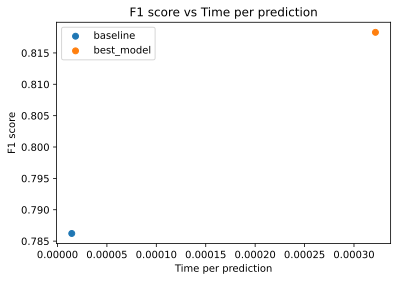

In [ ]:
# plotting inference time vs f1_score
plt.figure(figsize=(6,4))
plt.scatter(baseline_time_per_pred,baseline_results['f1_score'],label='baseline')
plt.scatter(best_model_time_per_pred,model_6_results['f1_score'],label='best_model')
plt.legend()
plt.title('F1 score vs Time per prediction')
plt.xlabel('Time per prediction')
plt.ylabel('F1 score')
plt.show()